# Results wPCC inverse dynamics

In [632]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [633]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from vessel_manoeuvring_models import IMO_evaluation
from sklearn.metrics import mean_squared_error, r2_score

In [634]:
ship_name = "wPCC"

In [663]:
#%reload_kedro
loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL").items()}
loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia']
loaders.pop('polynomial rudder complex')  # for now...

[11/22/24 16:22:23] INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder_MDL'          ]8;id=863502;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=775634;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=301162;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=463368;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

<bound method AbstractDataset.load of <phd.extras.datasets.model_dataset.ModularVesselSimulatorDataSet object at 0x7fc9eb671030>>

In [664]:
models = {name:loader() for name,loader in loaders.items()}
model = models["semiempirical rudder"]

In [665]:
meta_datas_all = catalog.load(f"{ship_name}.test_meta_data")

mask = meta_datas_all['test_type']=='zigzag'
meta_datas_all = meta_datas_all.loc[mask].copy()

meta_datas = meta_datas_all.loc[[22770,22772,]].copy()
#meta_datas = meta_datas.loc[[22770,22772,22773]].copy()


[11/22/24 16:22:28] INFO     Loading data from 'wPCC.test_meta_data' (CSVDataSet)...            ]8;id=722841;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=969958;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [666]:
meta_datas_all[['name','ship_speed']]

,name,ship_speed
22762,zigzag -10/-10 stbd,0.96177
22763,zigzag -10/-10 stbd,0.96177
22764,zigzag -10/-10 stbd,0.96177
22765,zigzag 10/10 port,0.96177
22768,zigzag 10/10 port,0.96177
22769,zigzag 10/10 port,0.96177
22770,zigzag 10/10 port,0.96177
22771,zigzag -20/-20 stbd,0.96177
22772,zigzag -20/-20 stbd,0.96177
22773,zigzag 20/20 port,0.96177


## Compare forces

In [667]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
df_VCT = add_mirrored(df_VCT)

#model = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']()
df_VCT_hydro = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=521941;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=881679;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [697]:
round = {
    'u':4,
    'v':4,
    'r':3,
    'delta':4,
}

keys_rounded = [f"{key}_round" for key in round.keys()]

for key,decimals in round.items():
    df_VCT_hydro[f"{key}_round"] = np.round(df_VCT_hydro[key], decimals=decimals)

_=[]
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    for key,decimals in round.items():
        df_EKF_smooth[f"{key}_round"] = np.round(df_EKF_smooth[key], decimals=decimals)

    df_EKF_smooth['time'] = df_EKF_smooth.index

    mask = df_EKF_smooth.duplicated(keys_rounded)
    df_ = df_EKF_smooth.loc[~mask]
    
    points = pd.merge(left=df_, right=df_VCT_hydro, how='inner', left_on=keys_rounded, right_on=keys_rounded, suffixes=('','_vct'))
    points.set_index('time', inplace=True)
    assert points.index.is_unique
    points['id'] = id
    #points_all[id]=points
    _.append(points)

points_all = pd.concat(_)
points_all['id'] = points_all['id'].astype(int)

[11/22/24 17:55:38] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=920171;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=824120;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=967321;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=17223;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [669]:
styles['polynomial rudder simple'] = styles['polynomial rudder']
styles['polynomial rudder complex'] = {'style':'m-','label':'complex'}

In [829]:
#model.parameters['Nr']=2*-0.0005802292840541036

[11/25/24 10:06:59] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=853877;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=592840;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests' (PartitionedDataset)...             ]8;id=366547;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=877940;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/25/24 10:07:00] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=785743;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=947217;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests' (PartitionedDataset)...             ]8;id=845415;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=250067;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

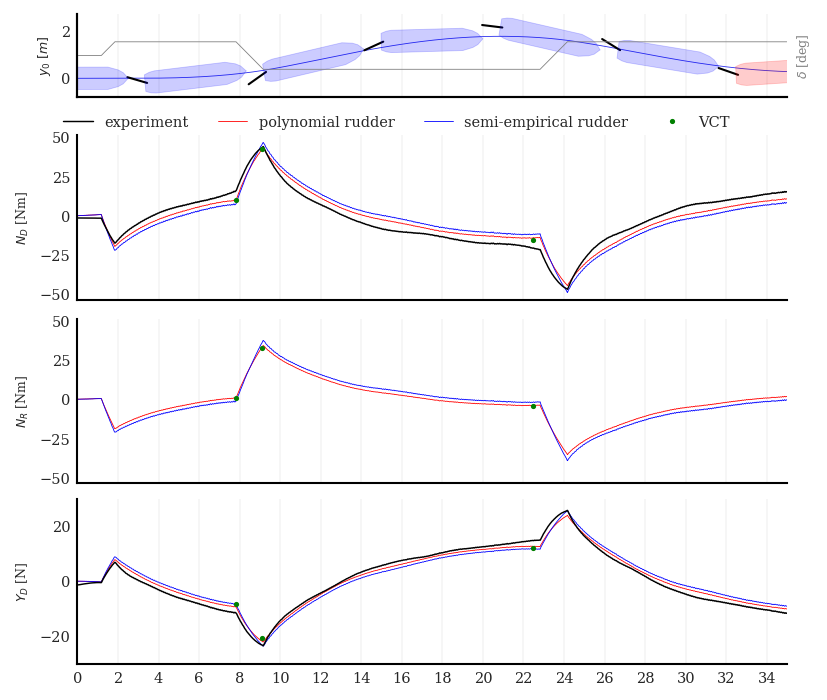

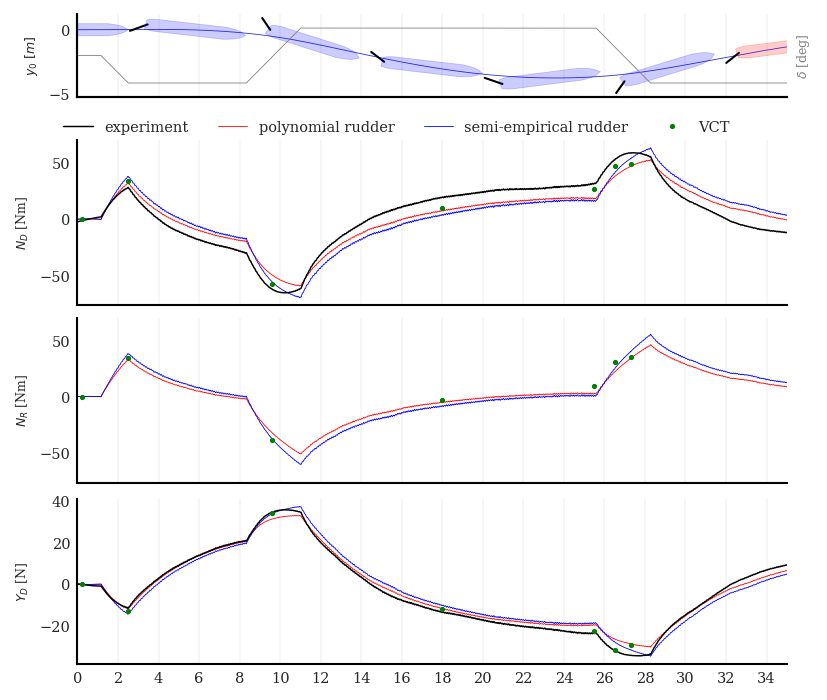

In [830]:
t_maxs = {
    22770 : 35,
    22772 : 35,
    22773 : 35,
}

for id, meta_data in meta_datas.iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha_port']
    keys=['N_D','N_R','Y_D',]
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units, symbols=symbols);
    
    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)

    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.20), ncol=4)


    
    loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
    
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    fig.set_size_inches(paper.figure_width,1.5*paper.figure_height)
    paper.save_fig(fig, f"{file_name}.svg")
    

In [831]:
_ = []
for id, meta_data in meta_datas.iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)

        data = df_EKF_smooth.loc[points.index]
        forces_from_motions = model.forces_from_motions(data=data)
        forces_from_motions['id'] = id
        _.append(forces_from_motions)

forces_from_motions_all = pd.concat(_)
forces_from_motions_all['model'] = 'experiment'

[11/25/24 10:07:01] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=845374;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=145602;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=940816;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=294498;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [832]:
points_all['model'] = 'CFD'
points_all.sort_values(by=['id','time'], inplace=True)

_ = []
for name, model_ in models.items():
    df_ = predict(model=model_, data=points_all)
    df_['model'] = name
    _.append(df_)
    
df_point_predictions = pd.concat([points_all, forces_from_motions_all] + _)

In [833]:
keys = ['N_D','N_R','Y_D','Y_R']
df_point_predictions[keys+['id','model']]

,N_D,N_R,Y_D,Y_R,id,model
time,,,,,,
7.800002,9.870011,0.675881,-8.401752,-0.265443,22770,CFD
9.100007,42.415117,32.859485,-20.564237,-13.321126,22770,CFD
22.480005,-15.352264,-4.371840,11.915230,1.779936,22770,CFD
0.219999,0.041477,-0.011093,-0.022601,0.004437,22772,CFD
2.499984,33.884326,34.774769,-12.625982,-14.111963,22772,CFD
9.599986,-57.343263,-39.114812,33.830909,15.898764,22772,CFD
17.999990,10.023098,-3.186894,-11.784648,1.279780,22772,CFD
25.500002,26.755433,9.304509,-22.623295,-3.864817,22772,CFD
26.499988,47.293146,30.447108,-31.281995,-12.408014,22772,CFD


<Axes: xlabel='time'>

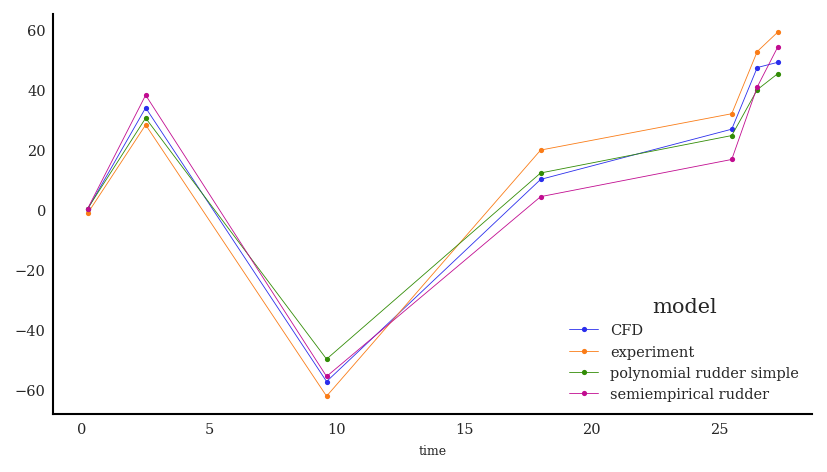

In [834]:
df_ = df_point_predictions.groupby('id').get_group(22772)[keys+['id','model']]
df_['time'] = df_.index
df_pivot = df_.pivot(index='time', columns='model')
df_pivot[keys].plot(y='N_D', style='.-')

<Axes: xlabel='time'>

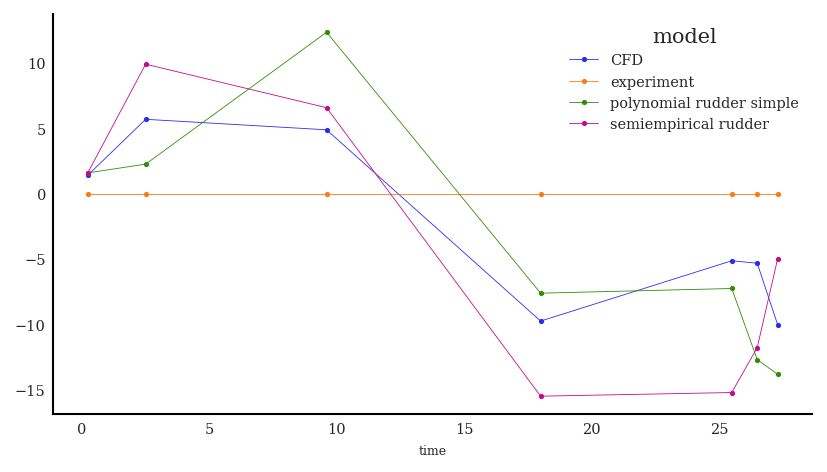

In [835]:
df_pivot['N_D'].sub(df_pivot['N_D']['experiment'], axis=0).plot(style='.-')

In [836]:
np.sqrt(mean_squared_error(y_true=df_pivot['N_D']['experiment'], y_pred=df_pivot['N_D']['CFD']))

6.646471340138838

In [837]:
for name in df_pivot['N_D'].columns:
    score = pd.Series(name=name)
    score['N_D'] = np.sqrt(mean_squared_error(y_true=df_pivot['N_D']['experiment'], y_pred=df_pivot['N_D'][name]))

In [838]:
df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)

data = df_EKF_smooth
forces_from_motions = model.forces_from_motions(data=data)
force_predictions = {name:predict(model=model, data=data) for name, model in models.items()}

[11/25/24 10:07:03] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=491134;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=369921;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests' (PartitionedDataset)...             ]8;id=260907;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=712241;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [839]:
keys = ['Y_D','N_D']
_ = []
for name, df_prediction in force_predictions.items():
    score = pd.Series(name=name)
    for key in keys:
        score[key] = np.sqrt(mean_squared_error(y_true=forces_from_motions[key], y_pred=df_prediction[key]))

    _.append(score)

scores = pd.DataFrame(_)


In [840]:
scores

,Y_D,N_D
polynomial rudder simple,2.774687,10.562555
semiempirical rudder,3.711012,13.505762


<Axes: >

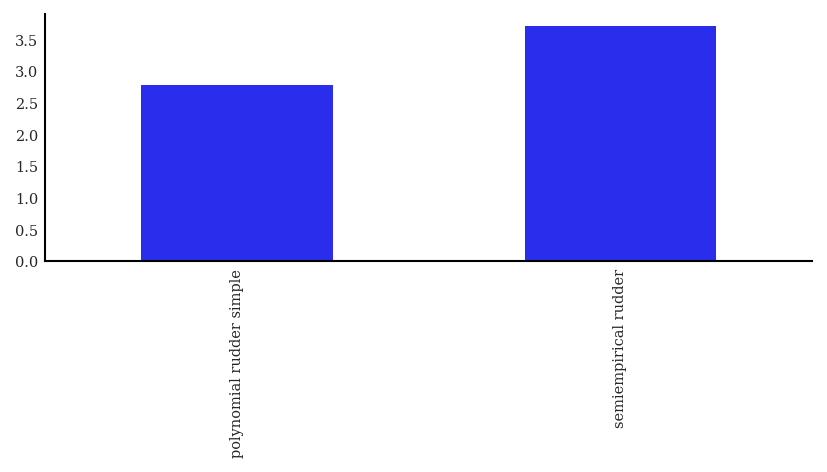

In [841]:
scores['Y_D'].plot.bar()

<Axes: >

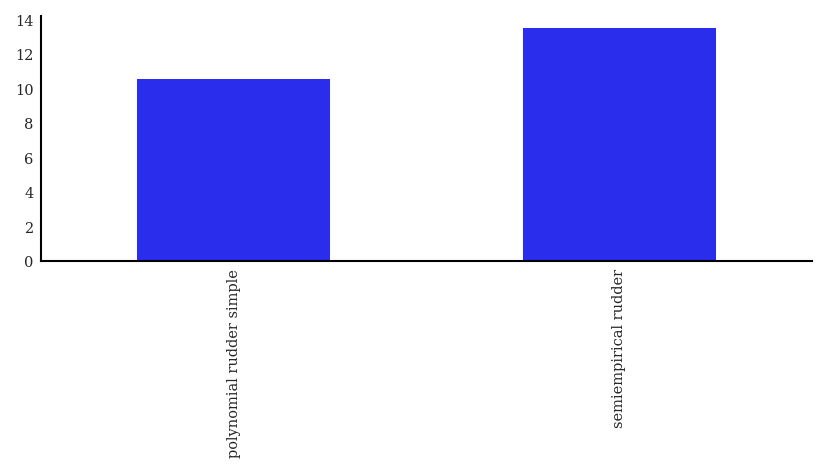

In [842]:
scores['N_D'].plot.bar()

## Closed loop simulation

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=578160;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=386511;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/25/24 10:07:07] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=393716;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=385967;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

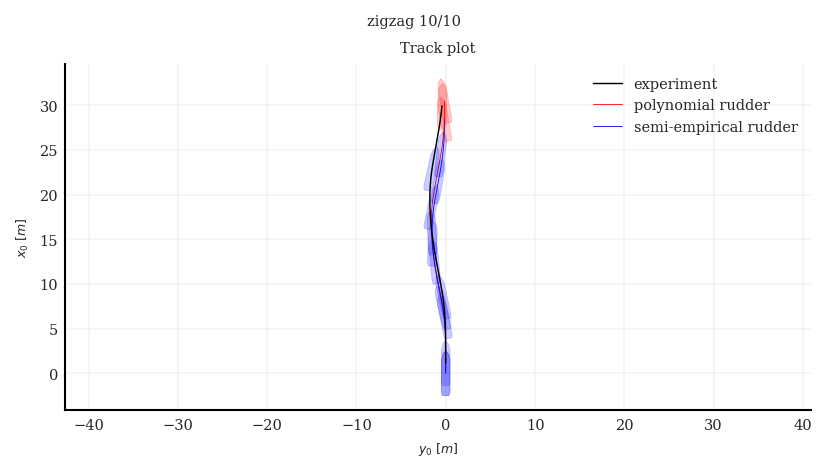

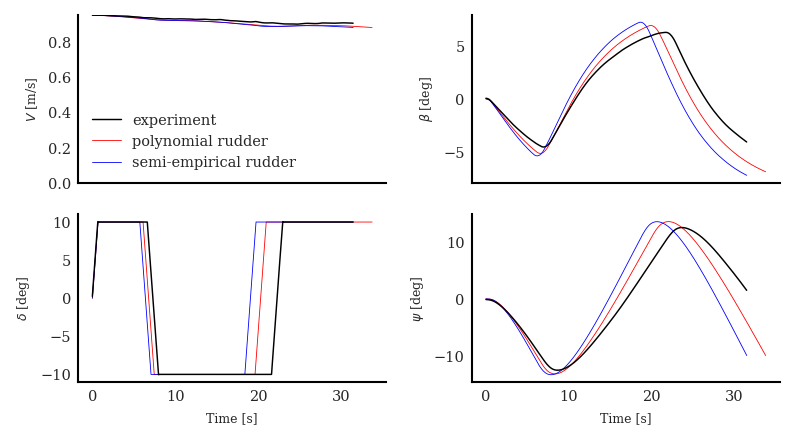

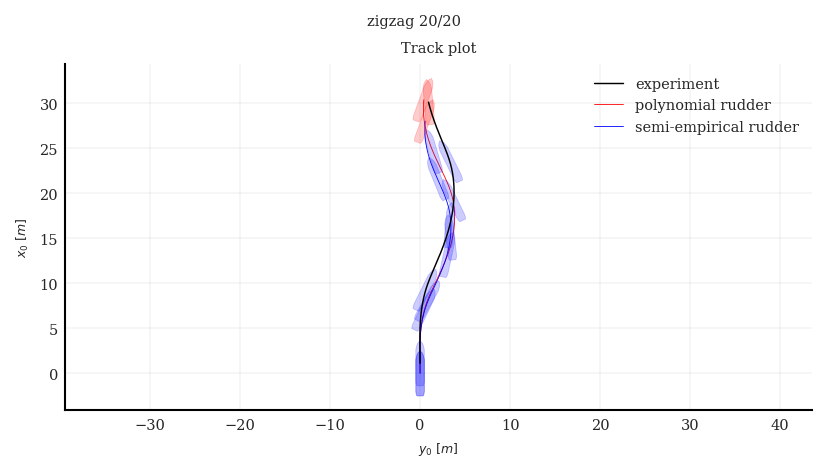

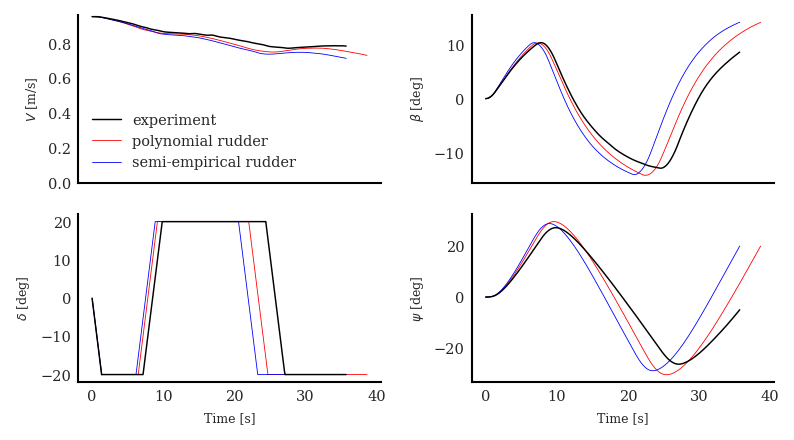

In [843]:
simulations = {}

for angle, group in meta_datas.groupby(by='angle1'):

    fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        try:
            df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        except:
            continue
        
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():
        
            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            angle = zigzag_angle(data_MDL=data)
        
            df_simulation = simulate_closed_loop(model=model,data=data)

            if not id in simulations:
                simulations[id] = {}

            simulations[id][model_name] = df_simulation
        
            direction = "port" if angle > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation

        dataframes['Experiment'] = dataframes['Experiment'].loc[-1:df_simulation.index[-1]].copy()

        if not id in meta_datas.index:
            continue
        
        track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        fig = ax.get_figure()
        direction = "port" if angle > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta','V','delta'], units=units, styles=styles, ncols=2, include_label=include_label, symbols=symbols);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        for ax in fig.axes:
            ax.grid(False)
        
        #fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"closed loop {file_name}.svg")
        
        
        include_label=False

In [844]:
def pack_overshoots(overshoots):
    overshoot_result = {}
    for n,(time, overshoot) in enumerate(overshoots.items()):  
        overshoot_result[f'overshoot_{n+1}'] = overshoot
        overshoot_result[f't_{n+1}'] = time

    return overshoot_result

In [845]:
_ = []
for id, meta_data in meta_datas_all.iterrows():
    
    try:
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    except:
        continue
    #df_EKF_smooth = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    overshoots = IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=meta_data['angle'])
    overshoot_result = pack_overshoots(overshoots)
    overshoot_result = pd.Series(overshoot_result, name=id)
    overshoot_result['angle'] = meta_data['angle']
    
    
    _.append(overshoot_result)
    
overshoot_results = pd.DataFrame(_)

[11/25/24 10:07:12] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=18492;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=352379;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=313121;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=718908;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=616283;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=938565;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=609617;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=210461;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=807870;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=849219;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=370883;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=880545;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=316056;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=870230;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=563241;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=724483;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=334779;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=329021;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=608937;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=548986;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=950259;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=286890;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=795102;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=546457;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=344360;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=561182;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=458821;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=380532;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=285896;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=5123;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=842982;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=554555;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [846]:
overshoot_results['angle'] = overshoot_results['angle'].abs()

In [847]:
overshoot_experiment_mean = overshoot_results.groupby(by='angle').mean()
overshoot_experiment_mean['model_name'] = 'Experiment'
overshoot_experiment_mean['angle'] = overshoot_experiment_mean.index

In [848]:
overshoot_experiment_mean

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,overshoot_4,t_4,model_name,angle
angle,,,,,,,,,,
10.0,2.401620,9.725009,2.493259,24.790015,2.387873,40.115012,2.286556,56.000006,Experiment,10.0
20.0,7.091187,10.944995,6.156289,28.284988,5.767094,46.435001,5.595757,64.589986,Experiment,20.0


In [849]:
overshoot_results.groupby(by='angle').std()

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,overshoot_4,t_4
angle,,,,,,,,
10.0,0.189077,0.148491,0.083907,0.070732,0.028753,0.049505,0.064275,0.098999
20.0,0.004095,0.106056,0.181747,0.021212,0.031605,0.162644,0.066145,0.141426


In [850]:
_ = []
for id, model_simulations in simulations.items():

    meta_data = meta_datas_all.loc[id]
    
    for model_name, df_simulation in model_simulations.items():
        
        overshoots = IMO_evaluation.measure_overshoots(df_simulation, angle=meta_data['angle'])
        overshoot_result = pack_overshoots(overshoots)
        overshoot_result['id'] = id
        overshoot_result['model_name'] = model_name
        overshoot_result['angle'] = meta_data['angle']
        _.append(overshoot_result)
    
overshoot_simulation_results = pd.DataFrame(_)
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].abs()
overshoot_simulation_results = pd.concat((overshoot_simulation_results,overshoot_experiment_mean,))

In [851]:
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].astype(int)

In [852]:
overshoot_simulation_results

,overshoot_1,t_1,overshoot_2,t_2,id,model_name,angle,overshoot_3,t_3,overshoot_4,t_4
0.0,3.246139,8.340000,3.654745,22.040000,22770.0,polynomial rudder simple,10,NaN,NaN,NaN,NaN
1.0,3.387275,7.870000,3.640512,20.640000,22770.0,semiempirical rudder,10,NaN,NaN,NaN,NaN
2.0,9.543871,9.580000,10.485020,25.420000,22772.0,polynomial rudder simple,20,NaN,NaN,NaN,NaN
3.0,8.787307,8.950000,8.928213,23.490000,22772.0,semiempirical rudder,20,NaN,NaN,NaN,NaN
10.0,2.401620,9.725009,2.493259,24.790015,NaN,Experiment,10,2.387873,40.115012,2.286556,56.000006
20.0,7.091187,10.944995,6.156289,28.284988,NaN,Experiment,20,5.767094,46.435001,5.595757,64.589986


In [853]:
def get_name(row):
    angle = row.name
    name = f"{abs(angle):0.0f}/{abs(angle):0.0f}"
    return name

In [854]:
def get_colors(overshoot_simulation_results_pivot):
    colors = []
    for name in overshoot_simulation_results_pivot.columns:
        if name=='name':
            continue
    
        style= styles[name]
        color = style.get('color',style['style'][0])
        colors.append(color)
    return colors

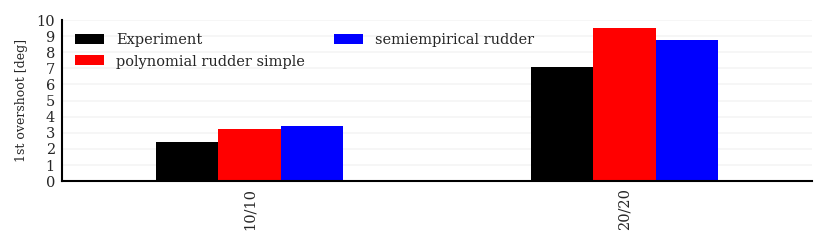

In [855]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_1')
colors = get_colors(overshoot_simulation_results_pivot)

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)
    

ax.legend(ncols=2)
ax.set_xlabel('')
ax.set_ylabel('1st overshoot [deg]')

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot1.svg")

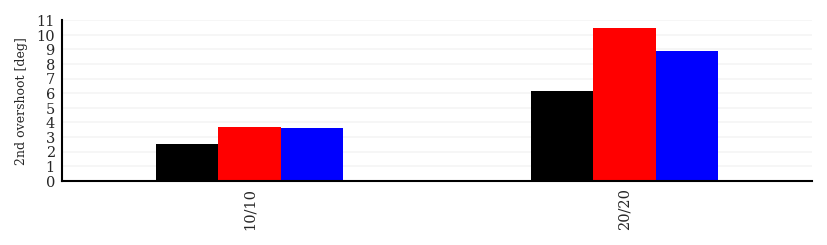

In [856]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_2')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)

#ax.legend(ncols=3)
ax.get_legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('2nd overshoot [deg]')

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot2.svg")

In [857]:
model.ship_parameters


{
    'T': 0.2063106796116504,
    'L': 5.014563106796117,
    'CB': 0.45034232324249973,
    'B': 0.9466019417475728,
    'rho': 1000,
    'x_G': -0.23989669902912625,
    'm': 441.0267843660858,
    'I_z': 742.0462794081202,
    'volume': 0.4410267843660858,
    'scale_factor': 41.2,
    'x_r': -2.45,
    'TWIN': 1,
    'x_p': -2.42219908951329,
    'y_p_port': -0.2176,
    'y_p_stbd': 0.2176,
    'z_p': 0.12730849514563097,
    'y_R_port': -0.2176,
    'y_R_stbd': 0.2176,
    'D': 0.12135922330097086,
    'A_XV': 0.5938354227542653,
    'A_YV': 3.3958124999999995,
    'rho_A': 1.225,
    'n_prop': 2,
    'tdf': 0.117,
    'A_R': 0.030095732397021395,
    'b_R': 0.17427184466019416,
    'c_r': 0.19247572815533978,
    'c_t': 0.1529126213592233,
    'x_fan_fore': 1.2877184466019416,
    'x_fan_aft': -1.5381815533980583,
    'y_fan_aft': 0,
    'y_fan_fore': 0,
    'r_0': 0.06067961165048543,
    'x': 0.027800910486710073,
    'x_R': -2.45,
    'y_R': 0,
    'z_R': 0,
    'A_R_C': 0.0